In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Dropout, LayerNormalization
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


### 1. load Data

In [3]:
#load data
data = pd.read_csv("data/fold_0_data.txt",sep = "\t" )
data1 = pd.read_csv("data/fold_1_data.txt",sep = "\t")
data2 = pd.read_csv("data/fold_2_data.txt",sep = "\t")
data3 = pd.read_csv("data/fold_3_data.txt",sep = "\t")
data4 = pd.read_csv("data/fold_4_data.txt",sep = "\t")

In [4]:
total_data = pd.concat([data, data1, data2, data3, data4], ignore_index=True)
print(total_data.shape) # should be 19370, 12

(19370, 12)


In [5]:
total_data.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


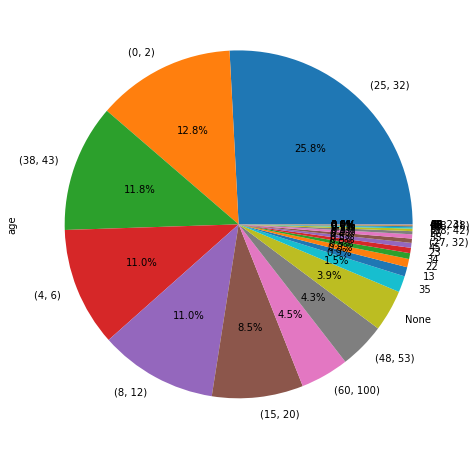

In [6]:
plt.figure(1, figsize=(8,8))
total_data.age.value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

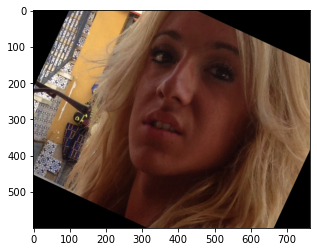

In [7]:
path = "data/faces/"+total_data.user_id.loc[0]+"/coarse_tilt_aligned_face."+str(total_data.face_id.loc[0])+"."+total_data.original_image.loc[0]
img = load_img(path)
plt.imshow(img)
plt.show()

### 2. preprocess data

In [8]:
df = total_data[['age', 'gender', 'x', 'y', 'dx', 'dy']].copy()
img_path = []
for row in total_data.iterrows():
    path = "data/faces/"+row[1].user_id+"/coarse_tilt_aligned_face."+str(row[1].face_id)+"."+row[1].original_image
    img_path.append(path)

df['img_path'] = img_path

In [9]:
df.head()

,age,gender,x,y,dx,dy,img_path
0,"(25, 32)",f,0,414,1086,1383,data/faces/30601258@N03/coarse_tilt_aligned_fa...
1,"(25, 32)",m,301,105,640,641,data/faces/30601258@N03/coarse_tilt_aligned_fa...
2,"(25, 32)",f,2395,876,771,771,data/faces/30601258@N03/coarse_tilt_aligned_fa...
3,"(25, 32)",m,752,1255,484,485,data/faces/30601258@N03/coarse_tilt_aligned_fa...
4,"(25, 32)",m,175,80,769,768,data/faces/30601258@N03/coarse_tilt_aligned_fa...


In [10]:
age_mapping = [('(0, 2)', '0-2'), ('2', '0-2'), ('3', '0-2'), ('(4, 6)', '4-6'), ('(8, 12)', '8-13'), 
               ('13', '8-13'), ('22', '15-20'), ('(8, 23)','15-20'), ('23', '25-32'), ('(15, 20)', '15-20'),
               ('(25, 32)', '25-32'), ('(27, 32)', '25-32'), ('32', '25-32'), ('34', '25-32'), ('29', '25-32'), 
               ('(38, 42)', '38-43'), ('35', '38-43'), ('36', '38-43'), ('42', '48-53'), ('45', '38-43'), 
               ('(38, 43)', '38-43'), ('(38, 42)', '38-43'), ('(38, 48)', '48-53'), ('46', '48-53'), 
               ('(48, 53)', '48-53'), ('55', '48-53'), ('56', '48-53'), ('(60, 100)', '60+'), 
               ('57', '60+'), ('58', '60+')]

In [11]:
age_mapping_dict = {each[0]: each[1] for each in age_mapping}
drop_labels = []
for idx, each in enumerate(df.age):
    if each == 'None':
        drop_labels.append(idx)
    else:
        df.age.loc[idx] = age_mapping_dict[each]

df = df.drop(labels=drop_labels, axis=0) #droped None values
df.age.value_counts(dropna=False)

C:\Users\yusha\.conda\envs\tf\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


25-32    5296
38-43    2776
0-2      2509
8-13     2292
4-6      2140
15-20    1792
48-53     916
60+       901
Name: age, dtype: int64

In [12]:
df = df.dropna()

In [13]:
X = df[['img_path']]
y = df[['age']]

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

encoder = LabelEncoder()
Y_encoded = encoder.fit_transform(y)
Y_onehot = np_utils.to_categorical(Y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, Y_onehot, test_size=0.3, random_state=42, shuffle=True)

print('Train data shape {}'.format(X_train.shape))
print('Test data shape {}'.format(X_test.shape))

Train data shape (12985, 1)
Test data shape (5566, 1)


C:\Users\yusha\.conda\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [15]:
train_images = []
test_images = []

for row in X_train.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))   # Resize the image
    data = np.asarray(image)
    train_images.append(data)

for row in X_test.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))  # Resize the image
    data = np.asarray(image)
    test_images.append(data)

train_images = np.asarray(train_images)
test_images = np.asarray(test_images)

print('Train images shape {}'.format(train_images.shape))
print('Test images shape {}'.format(test_images.shape))


Train images shape (12985, 227, 227, 3)
Test images shape (5566, 227, 227, 3)


In [16]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [17]:
np.random.seed(1000)

#Instantiation
model = Sequential()
model.add(Conv2D(input_shape=(227,227,3), filters=3,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=256, activation="softmax"))
model.add(Dense(units=8, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 227, 227, 3)       84        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 227, 227, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 113, 113, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 113, 113, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 113, 113, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

In [18]:
model.compile(loss = keras.losses.categorical_crossentropy, optimizer='Adam', metrics=['accuracy'])
history = model.fit(train_images, y_train, batch_size=64, epochs=15, validation_data=(test_images, y_test))

Epoch 1/15
203/203 [==============================] - 168s 733ms/step - loss: 2.0314 - accuracy: 0.2740 - val_loss: 1.9797 - val_accuracy: 0.2772
Epoch 2/15
203/203 [==============================] - 138s 678ms/step - loss: 1.9710 - accuracy: 0.2798 - val_loss: 1.9522 - val_accuracy: 0.2772
Epoch 3/15
203/203 [==============================] - 138s 678ms/step - loss: 1.9432 - accuracy: 0.2870 - val_loss: 1.9450 - val_accuracy: 0.2772
Epoch 4/15
203/203 [==============================] - 138s 679ms/step - loss: 1.9427 - accuracy: 0.2851 - val_loss: 1.9431 - val_accuracy: 0.2772
Epoch 5/15
203/203 [==============================] - 138s 680ms/step - loss: 1.9378 - accuracy: 0.2839 - val_loss: 1.9428 - val_accuracy: 0.2772
Epoch 6/15
203/203 [==============================] - 138s 679ms/step - loss: 1.9402 - accuracy: 0.2869 - val_loss: 1.9426 - val_accuracy: 0.2772
Epoch 7/15
203/203 [==============================] - 138s 678ms/step - loss: 1.9408 - accuracy: 0.2820 - val_loss: 1.9426 -

KeyboardInterrupt: 

In [24]:
model.save('age_model_final_vgg16.h5')

In [25]:
test_loss, test_acc = AlexNet.evaluate(test_images, y_test, verbose=2)
print(test_acc)

174/174 - 3s - loss: 1.3830 - accuracy: 0.6324
0.6324110627174377


In [26]:
print("Saved model to disk")
print(history.history.keys())

Saved model to disk
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


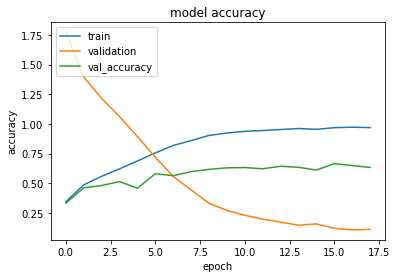

In [31]:
plt.show()

plt.plot(history.history['accuracy'])

plt.plot(history.history['loss'])

plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')

plt.ylabel('accuracy')

plt.xlabel('epoch')

plt.legend(['train', 'validation', 'val_accuracy'], loc='upper left')

plt.show()

In [60]:
import random 
sample_num = random.randint(0, test_images.shape[0]) 
test_sample = test_images[sample_num]

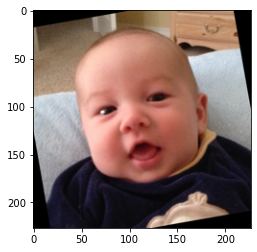

In [61]:
plt.imshow(test_sample)
plt.show()

In [62]:
predictions = AlexNet.predict(test_sample.reshape((-1,227,227,3)))
print('predicted probability: ' + str(predictions))

predicted_label = AlexNet.predict_classes(test_sample.reshape((-1,227,227,3)))
print("prediction labels: " , str(predicted_label))

predicted probability: [[9.9880815e-01 1.3608072e-04 1.9162569e-04 2.9957542e-04 2.6140598e-04
  1.3245844e-04 4.3267220e-05 1.2751762e-04]]
prediction labels:  [0]


In [63]:
encoder.inverse_transform(predicted_label)

array(['0-2'], dtype=object)